In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df = pd.read_csv('/kaggle/input/hearthstone-minions-stats-and-popularity/hearthstone_minions.csv')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hearthstone-minions-stats-and-popularity/hearthstone_minions.csv


In [2]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

columns_to_drop = ['url', 'CARDTYPE', 'COLLECTIBLE', 'ELITE', 'HAS_DIAMOND_QUALITY', 'MAX_SIDEBOARD_CARDS', 
                   'DECK_RULE_MOD_DECK_SIZE', 'TAG_SCRIPT_DATA_NUM_1', 'ENCHANTMENT_BIRTH_VISUAL', 
                   'ENCHANTMENT_IDLE_VISUAL', 'FACTION', 'AttackVisualType', 'DONT_PICK_FROM_SUBSETS', 
                   'IS_BACON_POOL_MINION', 'DECK_ACTION_COST', 'COLLECTION_RELATED_CARD_DATABASE_ID', 
                   'FORGES_INTO', 'TRIGGER_VISUAL', 'MINI_SET', 'TECH_LEVEL', 'MULTIPLE_CLASSES', 
                   'COST_UNHOLY', 'COST_FROST', 'COST_BLOOD', 'TAG_SCRIPT_DATA_NUM_2', 
                   'TRANSFORMED_FROM_CARD_VISUAL_TYPE', 'DECK_RULE_COUNT_AS_COPY_OF_CARD_ID', 'DevState',
                   'PLAYER_TAG_THRESHOLD_TAG_ID', 'PLAYER_TAG_THRESHOLD_VALUE', 'ENTITY_TAG_THRESHOLD_TAG_ID', 'ENTITY_TAG_THRESHOLD_VALUE',
                   'DISPLAY_CARD_ON_MOUSEOVER', 'USE_DISCOVER_VISUALS']
df = df.drop(columns=columns_to_drop, errors='ignore')

df['times_played'] = df['times_played'].str.replace(',', '').astype(int)
df = df[df['times_played'] >= 10]

valid_counts = df.count()
columns_to_drop = valid_counts[valid_counts < 5].index
df = df.drop(columns=columns_to_drop)

df = df[(df['avg_copies'] != '-') & (df['deck_winrate'] != '-')]

df['in_perc_of_decks'] = df['in_perc_of_decks'].str.replace('%', '').astype(float) / 100
df['deck_winrate'] = df['deck_winrate'].str.replace('%', '').astype(float) / 100
df['avg_copies'] = df['avg_copies'].astype(float)

df = df.fillna(0)
df = df[df['CARDRACE'] != 26]

df['DISCARD_CARDS'] = df['DISCARD_CARDS'].apply(lambda x: 1 if x != 0 else 0)
df['MULTI_CLASS_GROUP'] = df['MULTI_CLASS_GROUP'].apply(lambda x: 1 if x != 0 else 0)
df['RACE'] = pd.factorize(df['CARDRACE'])[0] + 1
df['CLASS'] = pd.factorize(df['CLASS'])[0] + 1
df['CARDRACE'] = df['CARDRACE'].apply(lambda x: 1 if x != 0 else 0)
df['MANATHIRST'] = df['MANATHIRST'].apply(lambda x: 1 if x != 0 else 0)

In [3]:
df = df[df['COST'] != 0]
df['Keyword'] = df.iloc[:, 10:-1].sum(axis=1)
df['Size'] = np.sqrt(df['HEALTH'] * df['ATK'])
df['SizeTrue'] = df['Size'] + 0.25 * df['Keyword']
df['Inflation'] = df['Size'] / df['COST']
df = df[df['CLASS'] != 13]
print(df.columns.tolist())

['card_name', 'in_perc_of_decks', 'avg_copies', 'deck_winrate', 'times_played', 'CLASS', 'RARITY', 'COST', 'HEALTH', 'ATK', 'BATTLECRY', 'DISCOVER', 'MANATHIRST', 'CARDRACE', 'TAUNT', 'TITAN', 'AURA', 'DEATHRATTLE', 'FREEZE', 'FORGE', 'DIVINE_SHIELD', 'CHARGE', 'HAS_SIGNATURE_QUALITY', 'MULTI_CLASS_GROUP', 'COMBO', 'CANT_BE_DAMAGED', 'OVERLOAD', 'REBORN', 'RUSH', 'DREDGE', 'SPELLPOWER', 'CORPSE', 'SECRET', 'MAGNETIC', 'WINDFURY', 'OUTCAST', 'POISONOUS', 'IMP', 'FINALE', 'LIFESTEAL', 'JADE_GOLEM', 'CHOOSE_ONE', 'INFUSE', 'COLOSSAL', 'START_OF_GAME', 'STEALTH', 'TRADEABLE', 'SILENCE', 'FRENZY', 'EMPOWER', 'SPELLBURST', 'CORRUPT', 'RITUAL', 'EVILZUG', 'DORMANT', 'ADAPT', 'DISCARD_CARDS', 'INSPIRE', 'ECHO', 'HONORABLEKILL', 'ENRAGED', 'RECRUIT', 'OVERHEAL', 'RACE', 'Keyword', 'Size', 'SizeTrue', 'Inflation']


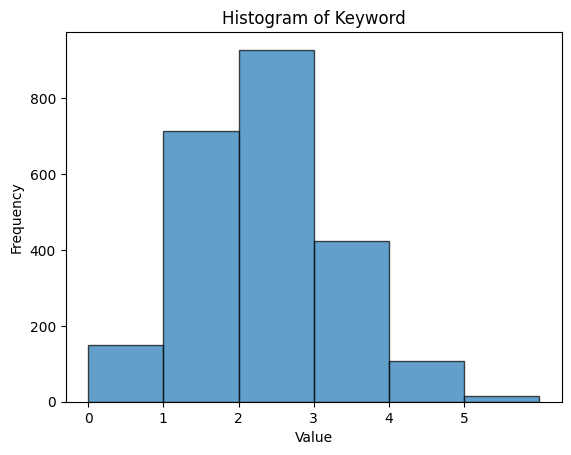

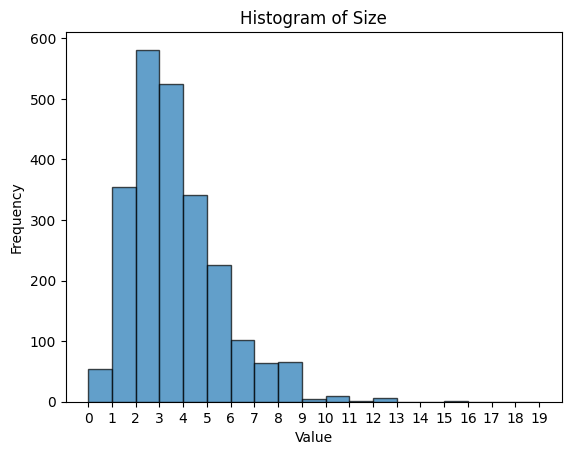

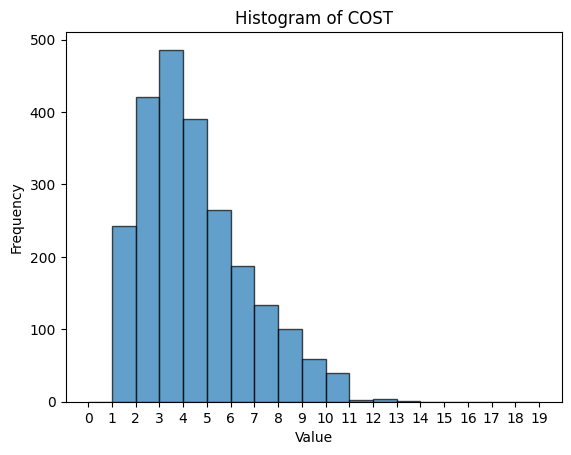

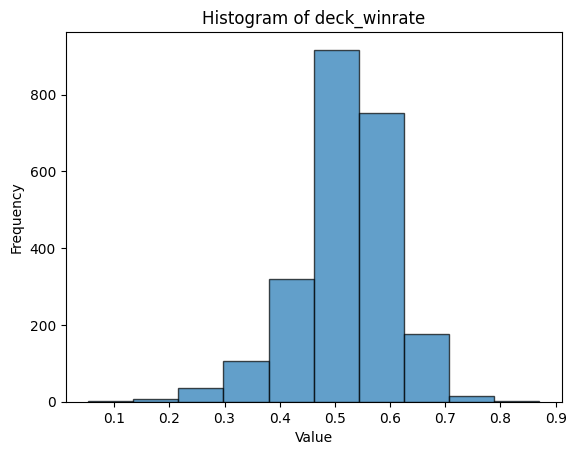

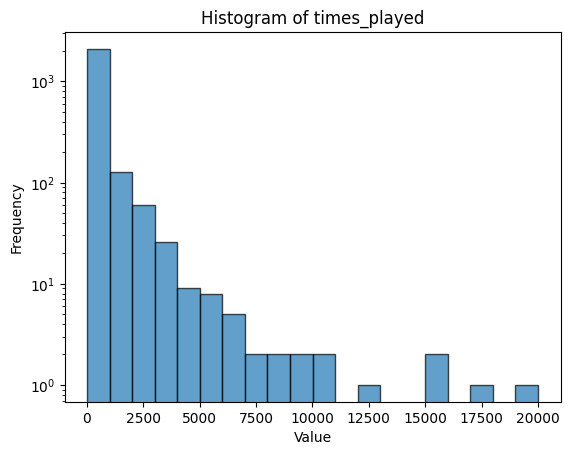

In [4]:
column_data = df['Keyword']

plt.hist(column_data, bins=range(0,7), edgecolor='black', alpha=0.7)
plt.title("Histogram of Keyword")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.xticks(range(0,6)) 
plt.show()

column_data = df['Size']

plt.hist(column_data, bins=range(0,20), edgecolor='black', alpha=0.7)
plt.title("Histogram of Size")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.xticks(range(0,20))
plt.show()

column_data = df['COST']

plt.hist(column_data, bins=range(0,20), edgecolor='black', alpha=0.7)
plt.title("Histogram of COST")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.xticks(range(0,20))
plt.show()

column_data = df['deck_winrate']

plt.hist(column_data, bins=10, edgecolor='black', alpha=0.7)
plt.title("Histogram of deck_winrate")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

column_data = df['times_played']

plt.hist(column_data, bins=20, edgecolor='black', alpha=0.7, log=True)
plt.title("Histogram of times_played")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


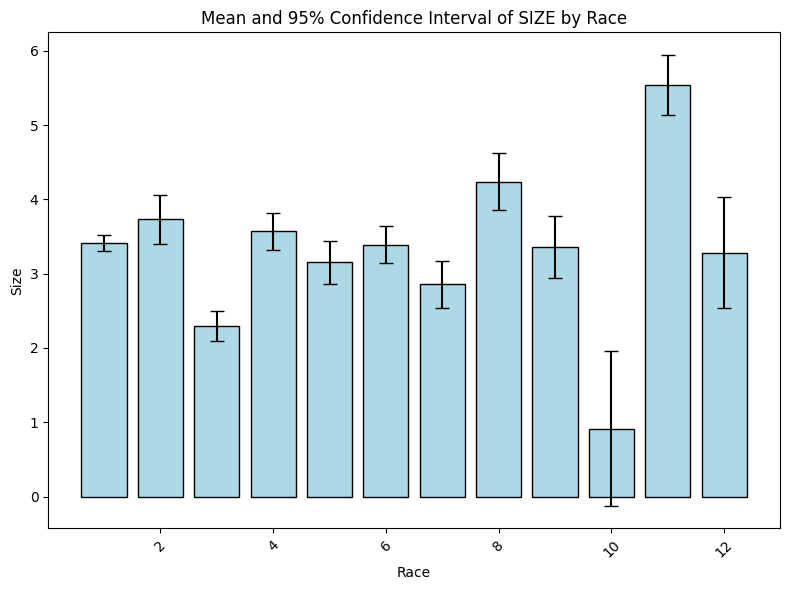

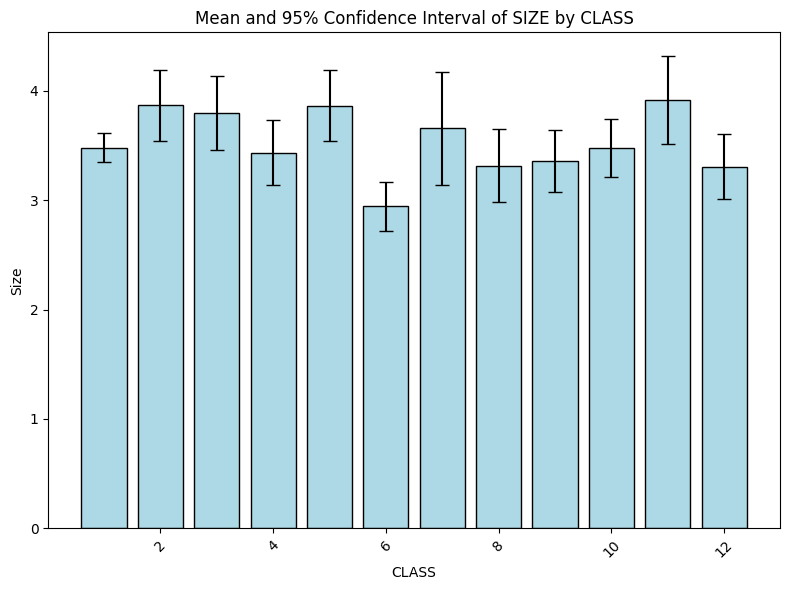

In [5]:
grouped = df.groupby('RACE')['Size'].agg(['mean', 'std', 'count']).reset_index()

grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])

confidence_level = 0.95
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2) 

grouped['ci_lower'] = grouped['mean'] - z_score * grouped['sem']
grouped['ci_upper'] = grouped['mean'] + z_score * grouped['sem']

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(grouped['RACE'], grouped['mean'], yerr=[grouped['mean'] - grouped['ci_lower'], grouped['ci_upper'] - grouped['mean']], 
       capsize=5, color='lightblue', edgecolor='black', label='Mean with CI')

ax.set_xlabel('Race')
ax.set_ylabel('Size')
ax.set_title('Mean and 95% Confidence Interval of SIZE by Race')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

grouped = df.groupby('CLASS')['Size'].agg(['mean', 'std', 'count']).reset_index()

grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])

grouped['ci_lower'] = grouped['mean'] - z_score * grouped['sem']
grouped['ci_upper'] = grouped['mean'] + z_score * grouped['sem']

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(grouped['CLASS'], grouped['mean'], yerr=[grouped['mean'] - grouped['ci_lower'], grouped['ci_upper'] - grouped['mean']], 
       capsize=5, color='lightblue', edgecolor='black', label='Mean with CI')

ax.set_xlabel('CLASS')
ax.set_ylabel('Size')
ax.set_title('Mean and 95% Confidence Interval of SIZE by CLASS')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

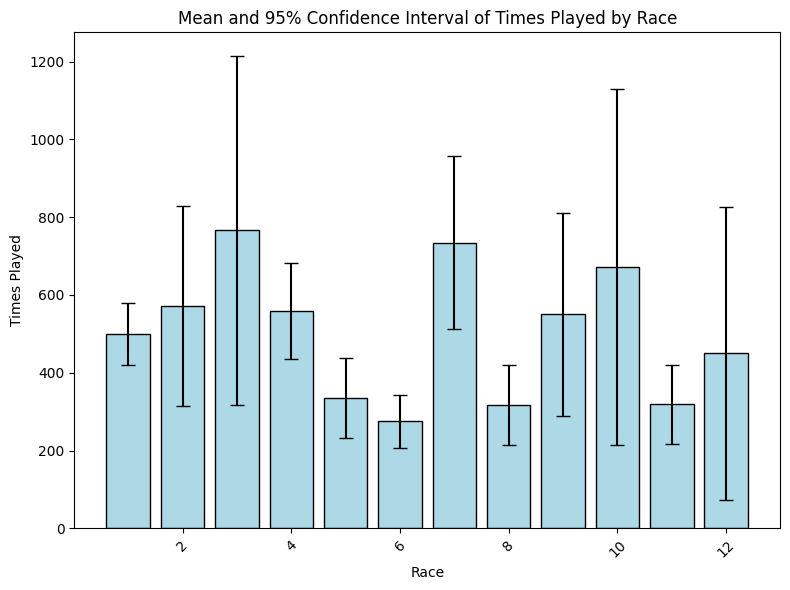

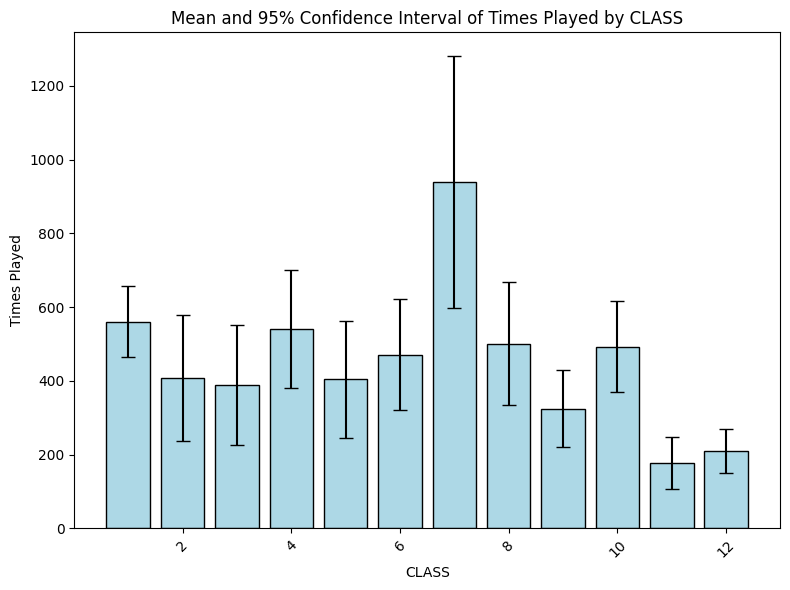

In [6]:

grouped = df.groupby('RACE')['times_played'].agg(['mean', 'std', 'count']).reset_index()

grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])

confidence_level = 0.95
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2) 

grouped['ci_lower'] = grouped['mean'] - z_score * grouped['sem']
grouped['ci_upper'] = grouped['mean'] + z_score * grouped['sem']

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(grouped['RACE'], grouped['mean'], yerr=[grouped['mean'] - grouped['ci_lower'], grouped['ci_upper'] - grouped['mean']], 
       capsize=5, color='lightblue', edgecolor='black', label='Mean with CI')

ax.set_xlabel('Race')
ax.set_ylabel('Times Played')
ax.set_title('Mean and 95% Confidence Interval of Times Played by Race')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

grouped = df.groupby('CLASS')['times_played'].agg(['mean', 'std', 'count']).reset_index()

grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])

grouped['ci_lower'] = grouped['mean'] - z_score * grouped['sem']
grouped['ci_upper'] = grouped['mean'] + z_score * grouped['sem']

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(grouped['CLASS'], grouped['mean'], yerr=[grouped['mean'] - grouped['ci_lower'], grouped['ci_upper'] - grouped['mean']], 
       capsize=5, color='lightblue', edgecolor='black', label='Mean with CI')

ax.set_xlabel('CLASS')
ax.set_ylabel('Times Played')
ax.set_title('Mean and 95% Confidence Interval of Times Played by CLASS')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


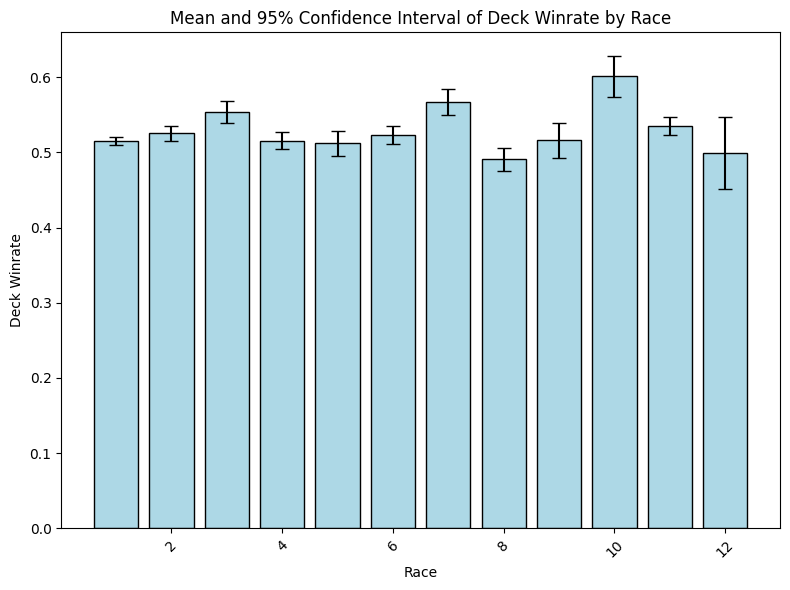

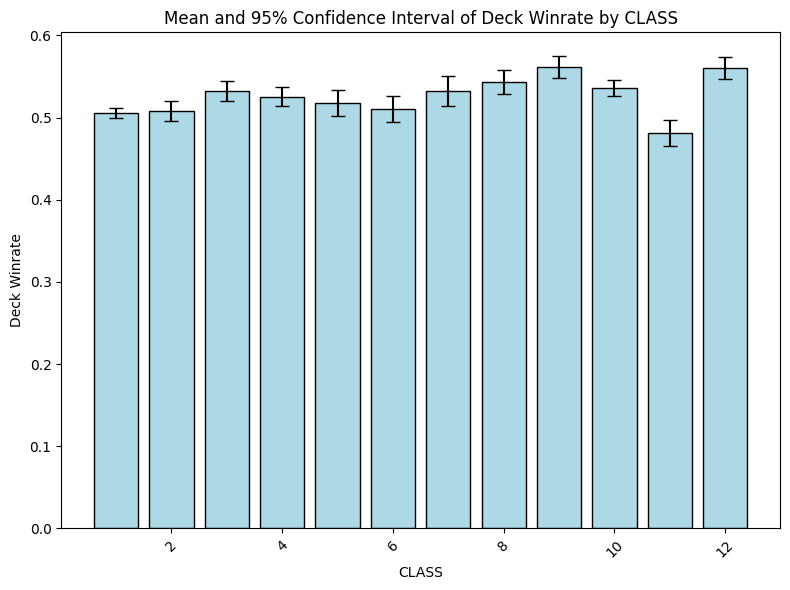

In [7]:
grouped = df.groupby('RACE')['deck_winrate'].agg(['mean', 'std', 'count']).reset_index()

grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])

grouped['ci_lower'] = grouped['mean'] - z_score * grouped['sem']
grouped['ci_upper'] = grouped['mean'] + z_score * grouped['sem']

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(grouped['RACE'], grouped['mean'], yerr=[grouped['mean'] - grouped['ci_lower'], grouped['ci_upper'] - grouped['mean']], 
       capsize=5, color='lightblue', edgecolor='black', label='Mean with CI')

ax.set_xlabel('Race')
ax.set_ylabel('Deck Winrate')
ax.set_title('Mean and 95% Confidence Interval of Deck Winrate by Race')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

grouped = df.groupby('CLASS')['deck_winrate'].agg(['mean', 'std', 'count']).reset_index()

grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])

grouped['ci_lower'] = grouped['mean'] - z_score * grouped['sem']
grouped['ci_upper'] = grouped['mean'] + z_score * grouped['sem']

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(grouped['CLASS'], grouped['mean'], yerr=[grouped['mean'] - grouped['ci_lower'], grouped['ci_upper'] - grouped['mean']], 
       capsize=5, color='lightblue', edgecolor='black', label='Mean with CI')

ax.set_xlabel('CLASS')
ax.set_ylabel('Deck Winrate')
ax.set_title('Mean and 95% Confidence Interval of Deck Winrate by CLASS')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [8]:
correlation_results = []
classes = df['CLASS'].unique()
for cls in classes:
    subset = df[df['CLASS'] == cls]
    if len(subset) > 1:  
        corr = subset[['Inflation', 'times_played']].corr().iloc[0, 1]
        corr1 = subset[['BATTLECRY', 'times_played']].corr().iloc[0, 1]
        corr2 = subset[['DEATHRATTLE', 'times_played']].corr().iloc[0, 1]
        corr3 = subset[['DISCOVER', 'times_played']].corr().iloc[0, 1]
        correlation_results.append({'CLASS': cls, 'Correlation_Size': corr, 'Correlation_BC': corr1, 'Correlation_DE': corr2, 'Correlation_DIS': corr3})

correlation_df = pd.DataFrame(correlation_results)
pd.set_option('display.float_format', '{:.4f}'.format)  
pd.set_option('display.colheader_justify', 'center')   
print(correlation_df.to_string(index=False))  

correlation_results = []
race = df['RACE'].unique()
for ra in race:
    subset = df[df['RACE'] == ra]
    if len(subset) > 1:  
        corr = subset[['Inflation', 'times_played']].corr().iloc[0, 1]
        corr1 = subset[['BATTLECRY', 'times_played']].corr().iloc[0, 1]
        corr2 = subset[['DEATHRATTLE', 'times_played']].corr().iloc[0, 1]
        corr3 = subset[['DISCOVER', 'times_played']].corr().iloc[0, 1]
        correlation_results.append({'RACE':ra, 'Correlation_Size': corr, 'Correlation_BC': corr1, 'Correlation_DE': corr2, 'Correlation_DIS': corr3})

correlation_df = pd.DataFrame(correlation_results)
pd.set_option('display.float_format', '{:.4f}'.format) 
pd.set_option('display.colheader_justify', 'center') 
print(correlation_df.to_string(index=False)) 


 CLASS  Correlation_Size  Correlation_BC  Correlation_DE  Correlation_DIS
   1         0.0811           0.1204         -0.0336          0.1069     
   2         0.1150           0.0871         -0.0345         -0.0425     
   3        -0.1070           0.0529         -0.0123          0.0585     
   4         0.0646          -0.1156          0.0911          0.2190     
   5         0.1514           0.0858         -0.0740          0.0202     
   6         0.2671           0.1403         -0.1166          0.1048     
   7         0.1240          -0.0276          0.1406          0.2945     
   8        -0.0358           0.0809         -0.1110         -0.0380     
   9         0.0924           0.0020         -0.0291          0.0569     
  10         0.1957           0.0707          0.0077          0.0711     
  11         0.0368          -0.1365         -0.1243         -0.0330     
  12         0.0440           0.1065         -0.1874          0.1942     
 RACE  Correlation_Size  Correlation_B

# Steps:
1. Split Dataset into CLASSes
2. Multivariate Regression
3. Train and Estimate
  
# Settings:
* Y: Popularity & Winning_rate
* X: Size, Cost, Keywords, (COMBO?)